<a href="https://colab.research.google.com/github/JAEHYEONG8121/hackathon/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA & 주요 인사이트

**컬럼 요약**
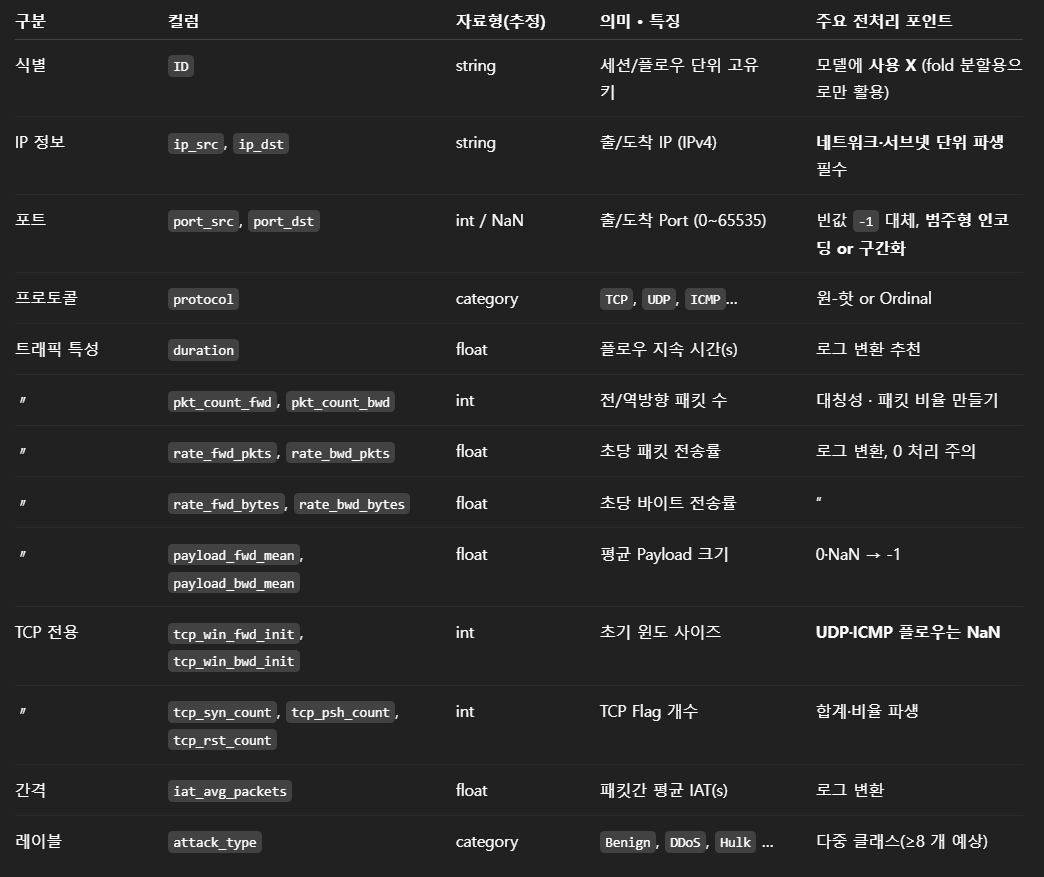

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# 1. 라이브러리 로드 & 데이터 읽기
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
plt.style.use("ggplot")

PATH = "/content/drive/MyDrive/CA/train.csv"
df = pd.read_csv(PATH)

print("shape:", df.shape)
df.head()

shape: (11999, 22)


,ID,ip_src,port_src,ip_dst,port_dst,protocol,duration,pkt_count_fwd,pkt_count_bwd,rate_fwd_pkts,rate_bwd_pkts,rate_fwd_bytes,rate_bwd_bytes,payload_fwd_mean,payload_bwd_mean,tcp_win_fwd_init,tcp_win_bwd_init,tcp_syn_count,tcp_psh_count,tcp_rst_count,iat_avg_packets,attack_type
0,TRAIN_00000,192.168.10.18,3721.0,192.168.10.243,55.0,UDP,0.000231,2,2,8656.974200,8656.974200,259709.226006,1.142721e+06,81.000000,81.000000,0,0,0,0,0,NaN,Benign
1,TRAIN_00001,192.168.10.5,NaN,NaN,91.0,TCP,0.000000,0,1,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0,16392,0,0,0,1.499097e+09,Benign
2,TRAIN_00002,172.16.0.182,NaN,192.168.10.18,83.0,TCP,0.606002,11,5,18.151760,8.250800,1727.717487,1.913360e+04,790.125000,790.125000,29200,28960,2,4,1,4.040012e-02,Hulk
3,TRAIN_00003,NaN,47668.0,192.168.10.18,NaN,TCP,1.003829,6,6,5.977114,5.977114,324.756507,1.155077e+04,993.416667,993.416667,29200,28960,3,2,0,9.125718e-02,Hulk
4,TRAIN_00004,192.168.10.5,51753.0,151.101.2.116,451.0,TCP,181.195271,62,89,NaN,0.491183,6.573019,6.896758e+02,NaN,NaN,8192,29200,2,22,0,NaN,Benign


attack_type
Benign             8791
Hulk               1719
Port_Scanning       793
DDoS                471
FTP_Brute_Force      47
GoldenEye            41
Slow_HTTP            34
SSH_Brute_Force      30
Botnet               27
Slowloris            26
Web_Brute_Force      14
Web_XSS               6
Name: count, dtype: int64


/tmp/ipython-input-8-2449732615.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cls_cnt.index, y=cls_cnt.values, palette="viridis")


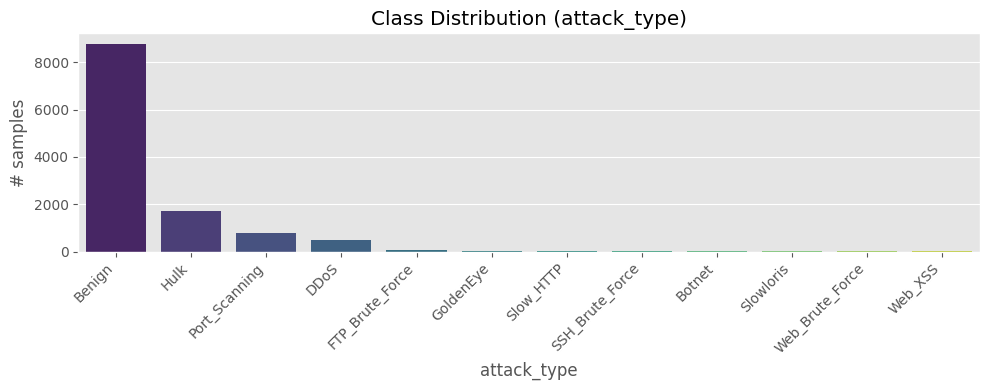

In [8]:
# 2. target(attack_type) 클래스 분포

cls_cnt = df["attack_type"].value_counts().sort_values(ascending=False)
print(cls_cnt)

plt.figure(figsize=(10, 4))
sns.barplot(x=cls_cnt.index, y=cls_cnt.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Class Distribution (attack_type)")
plt.ylabel("# samples")
plt.tight_layout()
plt.show()

,na_count,na_ratio(%)
port_src,3374,28.12
iat_avg_packets,2760,23.00
ip_src,2512,20.94
port_dst,2287,19.06
payload_fwd_mean,1785,14.88
payload_bwd_mean,1785,14.88
rate_bwd_pkts,1687,14.06
ip_dst,1304,10.87
rate_fwd_pkts,1171,9.76
duration,1074,8.95


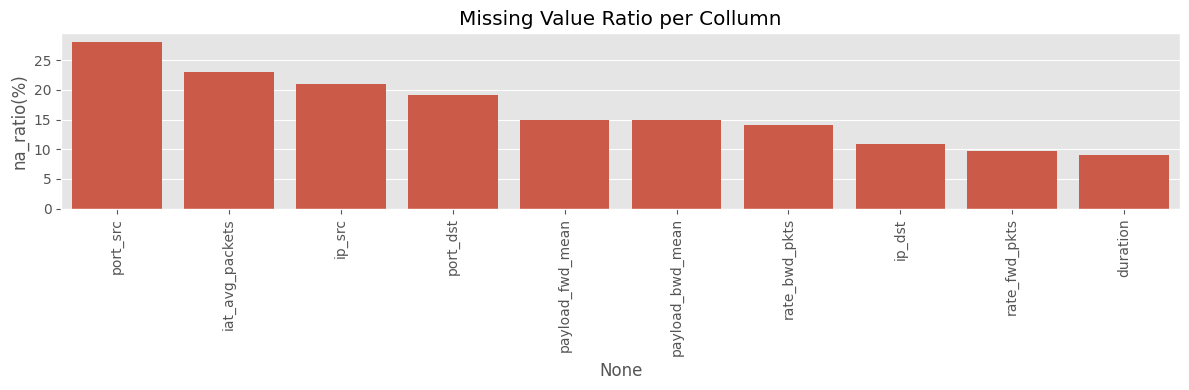

In [16]:
# 3. 전체 결측치 분포

na_sum = df.isna().sum()
na_table = na_sum[na_sum > 0].sort_values(ascending=False).to_frame("na_count")
na_table["na_ratio(%)"] = (na_table["na_count"] / len(df)*100).round(2)

display(na_table.head(20))

plt.figure(figsize=(12, 4))
sns.barplot(x=na_table.index, y="na_ratio(%)", data=na_table)
plt.xticks(rotation=90)
plt.title("Missing Value Ratio per Collumn")
plt.tight_layout()
plt.show()

,column,outlier_count
2,duration,2494
6,rate_bwd_pkts,2493
5,rate_fwd_pkts,2469
8,rate_bwd_bytes,2462
11,tcp_win_fwd_init,2459
16,iat_avg_packets,2214
7,rate_fwd_bytes,2001
1,port_dst,1714
10,payload_bwd_mean,1570
9,payload_fwd_mean,1570


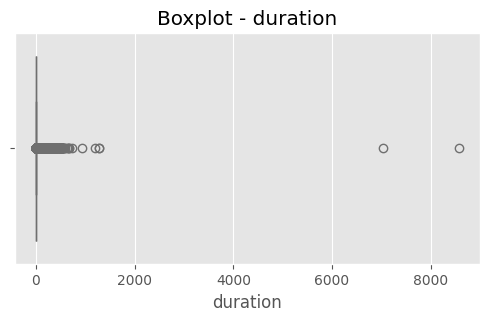

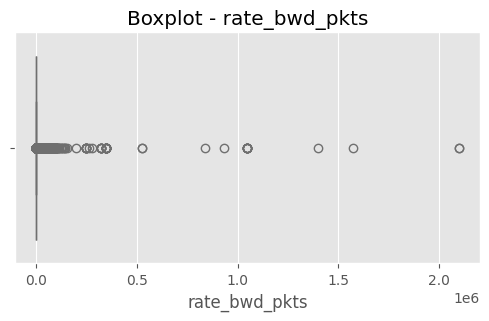

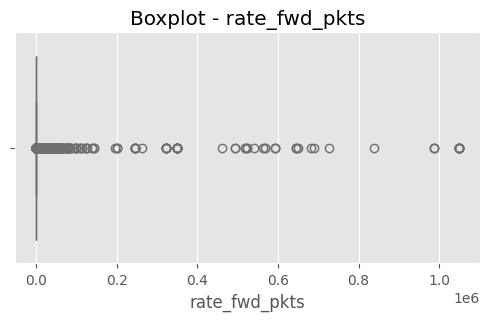

In [9]:
# 4. 숫자형 컬럼별 이상치 탐지 (IQR 기반)

# df.select_dtypes(include=None, exclude=None) : 특정 데이터 타입의 열만 선택해서 df으로 반환
# .columns : 앞에서 뽑은 숫자형 df에서 컬럼 이름만 가져옴 -> Index 객체가 됨
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

outlier_info = []
for col in num_cols:
  q1, q3 = df[col].quantile([0.25, 0.75])
  iqr = q3 - q1 # 데이터의 "중간 50%" 범위
  # IQR 기준 이상치 범위
  lower = q1 - 1.5 * iqr
  upper = q3 + 1.5 * iqr
  # .shape[0] : 행의 개수 = 이상치 개수
  out_cnt = df[(df[col] < lower) | (df[col] > upper)].shape[0]
  # (컬럼명, 이상치 개수) -> 튜플로 저장
  outlier_info.append((col, out_cnt))

out_df = pd.DataFrame(outlier_info, columns=["column", "outlier_count"]).sort_values("outlier_count", ascending=False)

display(out_df.head(20))

# 가장 이상치가 많은 상위 3개 컬럼 시각화
top3 = out_df.head(3)["column"].tolist()
for col in top3:
  plt.figure(figsize=(6, 3))
  sns.boxplot(x=df[col], color="skyblue")
  plt.title(f"Boxplot - {col}")
  plt.show()


                    count unique            top  freq           mean  \
ID                  11999  11999    TRAIN_11998     1            NaN   
ip_src               9487    517   172.16.0.182  2266            NaN   
port_src           8625.0    NaN            NaN   NaN    42746.90342   
ip_dst              10695   1901  192.168.10.18  2681            NaN   
port_dst           9712.0    NaN            NaN   NaN    6445.632619   
protocol            11999      2            TCP  8005            NaN   
duration          10925.0    NaN            NaN   NaN      16.712027   
pkt_count_fwd     11999.0    NaN            NaN   NaN      16.019168   
pkt_count_bwd     11999.0    NaN            NaN   NaN      20.222685   
rate_fwd_pkts     10828.0    NaN            NaN   NaN    6645.382033   
rate_bwd_pkts     10312.0    NaN            NaN   NaN    6627.535999   
rate_fwd_bytes    11999.0    NaN            NaN   NaN  320568.776422   
rate_bwd_bytes    11999.0    NaN            NaN   NaN  188760.73

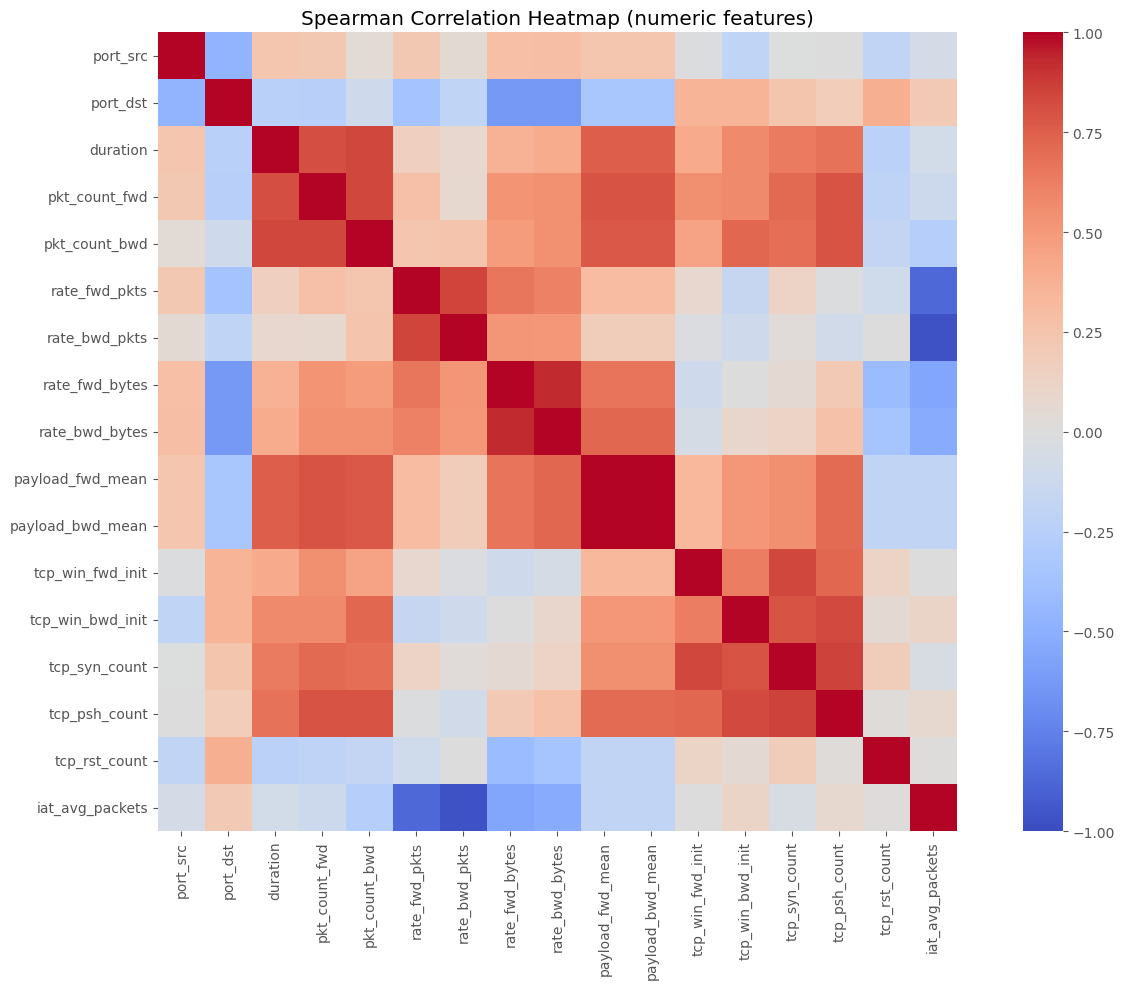

In [10]:
# 5. 컬럼별 기본 통계 & 상관관계 히트맵

print(df.describe(include="all").T.head(20))

plt.figure(figsize=(14, 10))
# .corr(method="spearman") : 상관관계 행렬을 계산하는 함수, "spearman" -> 순위 기반
corr = df[num_cols].corr(method="spearman")
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1, square=True)
plt.title("Spearman Correlation Heatmap (numeric features)")
plt.tight_layout()
plt.show()